## Математический маятник
Математический маятник является классической задачей в которой появляется система дифференциально-алгебраических уравнений (ДАУ) с высоким индексом (индекс задачи равен трём)

Уравнения, описывающие эволюцию маятника можно записать как систему

\begin{equation}
 \begin{cases}
   \dot x = v_x 
   \\
   \dot y = v_y
   \\
   \dot v_x = -\frac{xT}{mL}
   \\
   \dot v_y = -\frac{yT}{mL} - g
   \\
   0 = x^2 + y^2 - L^2
 \end{cases}
\end{equation}

Последнее уравнение является алгбраическим и ограничивает многобразие на котором может эволюционировать система. Всё движение возможно только по дуге окружности.

Индекс данной системы равен трем. Дифференцируя алгебраическое уравнение три раза можно получить системы соответственно индексов 2, 1, 0. Система индекса 0 это система ОДУ.

Система индекса 2 будет содержать уравнение:
\begin{equation}
 0 = x v_x + y v_y
\end{equation}

Система индекса 1 будет содержать уравнение:
\begin{equation}
 0 = v_x^2 + v_y^2 - \frac{TL}{m}-gy
\end{equation}

Система индекса 0 будет содержать уравнение:
\begin{equation}
 \dot T = -\frac{3mgv_y}{L}
\end{equation}

Решим все системы одним и тем же методом Розенброка на одной и той же сетке.

### Исходные данные

In [1]:
using Plots, LinearAlgebra

In [2]:
m, L, x0, y0, vx0, vy0, g = 1, 5, 5, 0, 0, 0, 9.81
T0 = (vx0^2 + vy0^2 - y0*g) * m / L

params = (L, m, g)

u0 = [x0 y0 vx0 vy0 T0]'

D = Diagonal([1, 1, 1, 1, 0]);
E = Matrix(I, 5, 5);

Оценим период колебаний маятника по формуле для малых колебаний (получается около 5 с) и примем шаг сетки 0,05 с (примерно 100 шагов на период)

In [3]:
step = 0.05;
time = 0: step: 20;

### Функции, определяющие систему дифференциально-алгебраический уравнений

In [4]:
function problemIndex(u, params, index)
    L, m, g = params
    x, y, vx, vy, T = u
    
    if index == 3
        [vx vy -x*T/m/L -y*T/m/L-g x^2+y^2-L^2]'
    elseif index == 2
        [vx vy -x*T/m/L -y*T/m/L-g x*vx+y*vy]'
    elseif index == 1
        [vx vy -x*T/m/L -y*T/m/L-g vx^2+vy^2-T*L/m-g*y]'
    elseif index == 0
        [vx vy -x*T/m/L -y*T/m/L-g -3m*g*vy/L]'
    else println("Индекс системы должен быть от нуля до трех")
    end
end;

### Функции, определяющие матрицу Якоби для систем разного индекса

In [5]:
function jacobianIndex(u, params, index)
    L, m, g = params
    x, y, vx, vy, T = u
    
    if index == 3
        lowerRow = [2x 2y 0 0 0]
    elseif index == 2
        lowerRow = [vx vy x y 0]
    elseif index == 1
        lowerRow = [0 -g 2vx 2vy -L/m]
    elseif index == 0
        lowerRow = [0 0 0 -3m*g/L 0]
    else println("Индекс системы должен быть от нуля до трех")
        return nothing
    end
    
    return [[0 0 1 0 0;
            0 0 0 1 0;
            -T/m/L 0 0 0 -x/m/L;
            0 -T/m/L 0 0 -y/m/L];
            lowerRow]
end;

## Функция, реализующая схему Розенброка

In [6]:
function solveEq(time, problem, jacobian, initVal, D, params, index)
    u = initVal
    h = time[2] - time[1]
    useries = u
    alpha = 1
#     alpha = ( 1 + im ) / 2
    
    for t in time[2: end]
        J = jacobian(u, params, index)
        w = ( D - alpha * h * J ) \ problem(u, params, index)
        u += h * real(w)

        useries = [useries u]
    end
    
    return useries[1, :], useries[2, :], useries[3, :], useries[4, :], useries[5, :]
end;

## Решение и анализ
### Индекс 3

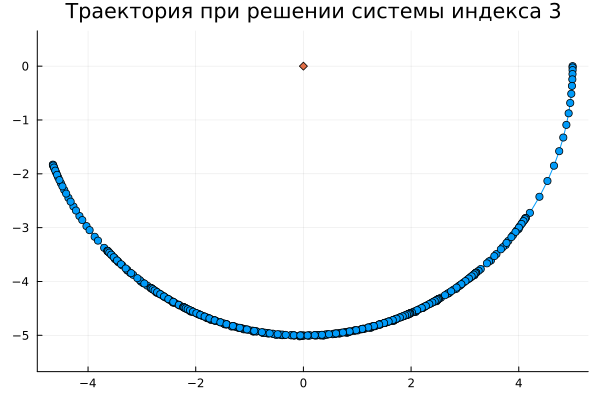

In [7]:
x, y, vx, vy, T = solveEq(time, problemIndex, jacobianIndex, u0, D, params, 3)
plot(x, y, markershape = :circle,
aspect_ratio = 1,
title = "Траектория при решении системы индекса 3",
legend = false)
plot!([0], [0], markershape = :diamond)

Груз всегда находится на окружности, что верно и является следствием учета 5-ого алгебраического уравнения системы. Колебания затухают со временем, что является неверным для этой системы и является следствием накопления погрешности численного счета. Увеличение порядка метода и уменьшение шага снижает данный эффект.

### Индекс 2

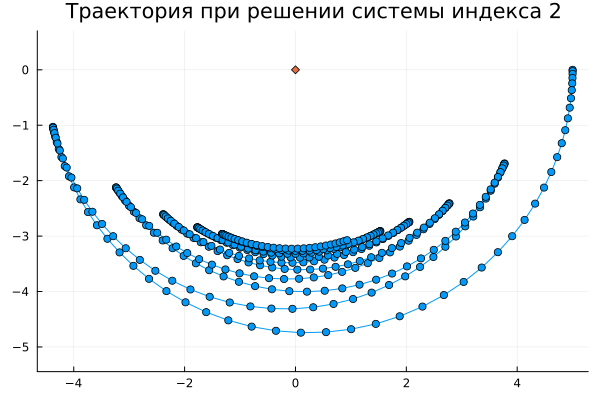

In [8]:
x, y, vx, vy, T = solveEq(time, problemIndex, jacobianIndex, u0, D, params, 2)
plot(x, y, markershape = :circle,
aspect_ratio = 1,
title = "Траектория при решении системы индекса 2",
legend = false)
plot!([0], [0], markershape = :diamond)

В дополнение к затуханию колебаний появилось смещение траектории на концентрические окружности. Это следствие замены алгебраического ограничения в виде уравнения окружности на его производную. Это приводит к расширению множества решений и численная схема дает решения в которых определяющим уже является не движение по окружности, а то что радиус-вектор перпендикулярен скорости. А это условия выполнено на всех концентрических окружностях.

### Индекс 1

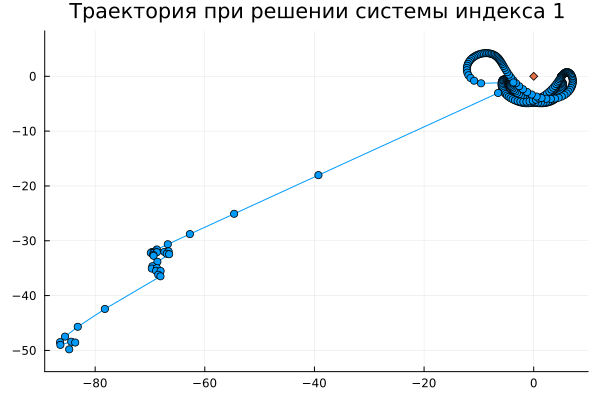

In [9]:
x, y, vx, vy, T = solveEq(time, problemIndex, jacobianIndex, u0, D, params, 1)
plot(x, y, markershape = :circle,
aspect_ratio = 1,
title = "Траектория при решении системы индекса 1",
legend = false)
plot!([0], [0], markershape = :diamond)

Решение при данном шаге перестало быть стабильно

#### Индекс 0 - система ОДУ

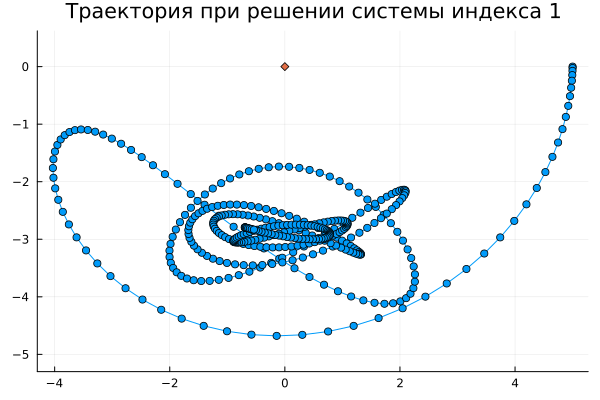

In [10]:
x, y, vx, vy, T = solveEq(time, problemIndex, jacobianIndex, u0, E, params, 0)
plot(x, y, markershape = :circle,
aspect_ratio = 1,
title = "Траектория при решении системы индекса 1",
legend = false)
plot!([0], [0], markershape = :diamond)

Для системы ОДУ такой шаг является также большим и эволюция системы описывается "верно" только первые пол периода колебаний. Полностью потеряна информация о том, что траектория движения груза изначально была ограничена окружностью.

## Выводы

Задача в перовначальной постановке (которая пришла из физики системы) наиболее полна по информации которую можно учесть при численном решении.

Понижение индекса системы приводит к расширению множества решений и численная схема может начать дрейфовать среди них.

Одновременно с этим многие численные методы в принципе не могут применяться для решения систем ДАУ с индексом выше одного, поэтому понижение индекса часто необходимая процедура.

Конкретно в рассмотренном примере с выбранным шагом сетки, методом решения и начальными условиями лушче всего себя показало решение системы ДАУ "в лоб" без предварительного снижения индекса системы.